# Project title: "Comparative Analysis of Image Classification Models using Diverse Approaches"


Project report submitted to : School of Continuing studies, University of Toronto, Canada

Certificate Program: Certificate in Artificial Intelligence

Course : Deep Learning (3546)

### Group Members: Harvinder Singh,  Harpreet Kaur Bargota 




Summary of Project:

In this comparative study, we evaluate the performance of various deep learning models, including a basic CNN, a hypertuned CNN, ResNet50V2, Vision Transformer constructed from scratch and pre-trained Vision Transformers, on a common dataset. Each model's architecture, training process, and evaluation metrics, such as accuracy, loss and computational efficiency, are carefully examined.

We also consider aspects like model complexity, training time, robustness to new data, and interpretability. The results, presented in tables and graphs, reveal the strengths and weaknesses of each approach, highlighting the trade-offs involved in choosing the most suitable model for specific tasks. This study aims to provide insights into the optimal use of these models in real-world applications.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re
import pathlib
import random
import tensorflow
from PIL import Image

import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import datetime
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Dataset:

The original dataset (https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification) had 10,000 images with 5 classes of fruits (2000 images per class). However, for learning, researching and exploring the deep learning models for better computational efficiency with limited time and resource, we selected 900 images with 300 images per class for 3 classes-Apple, Mango, and strawberry. The dataset of 900 images was split into train, valid and test set.

In [4]:
import zipfile
import os
import shutil

def extract_zip(zip_path, extract_to):
    """
    Extracts the zip file to the specified directory.

    Parameters:
    zip_path (str): Path to the zip file.
    extract_to (str): Directory where the contents will be extracted.

    Returns:
    str: Path to the extracted main folder.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    extracted_folder = os.path.join(extract_to, 'Fruit_class')
    return extracted_folder

def get_subfolder_info(folder_path):
    """
    Gets information about each sub-folder and counts the number of images in each.

    Parameters:
    folder_path (str): Path to the main folder containing sub-folders.

    Returns:
    dict: Dictionary containing sub-folder names as keys and image counts as values.
    """
    subfolder_info = {}
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            image_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
            subfolder_info[subfolder] = image_count
    return subfolder_info

# Example usage:
zip_path = '/content/drive/My Drive/Fruit_class_project.zip'
extract_to = '/content/Fruit_class_project'

# Ensure the extraction directory is clean
if os.path.exists(extract_to):
    shutil.rmtree(extract_to)
os.makedirs(extract_to)

# Extract the zip file
extracted_folder = extract_zip(zip_path, extract_to)

# Get information about each sub-folder and the number of images
subfolder_info = get_subfolder_info(extracted_folder)

# Display the information
for subfolder, image_count in subfolder_info.items():
    print(f"Sub-folder '{subfolder}' contains {image_count} images.")


Sub-folder 'Apple' contains 300 images.
Sub-folder 'Strawberry' contains 300 images.
Sub-folder 'Mango' contains 300 images.


Total images in 'Class_images': 900


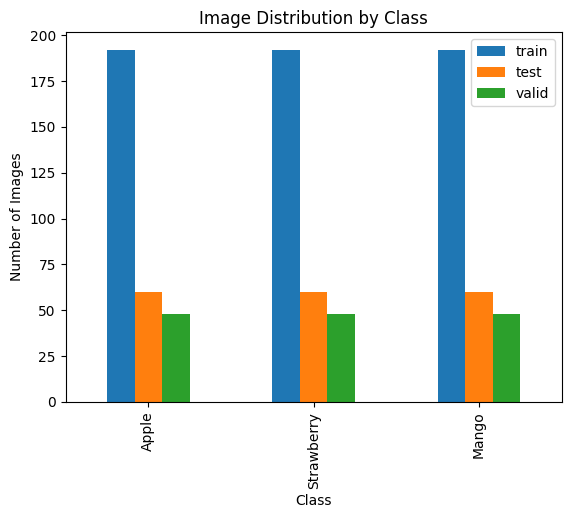

In [5]:
# Ensure the main directory structure is ready
base_dir = '/content/Fruit_class_project'
class_images_dir = os.path.join(base_dir, 'Class_images')

# Create main directories if they do not exist
os.makedirs(class_images_dir, exist_ok=True)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

for dir_path in [train_dir, test_dir, valid_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Combine all images into the 'Class_images' folder
extracted_folder = os.path.join(base_dir, 'Fruit_class')
for subfolder in os.listdir(extracted_folder):
    subfolder_path = os.path.join(extracted_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, filename)
            if os.path.isfile(file_path):
                shutil.copy(file_path, os.path.join(class_images_dir, f"{subfolder}_{filename}"))

# Count images in 'Class_images' folder
all_images = os.listdir(class_images_dir)
print(f"Total images in 'Class_images': {len(all_images)}")

# Create a DataFrame to hold file paths and class labels
data = []
for filename in all_images:
    class_label = filename.split('_')[0]
    data.append((filename, class_label))

df = pd.DataFrame(data, columns=['filename', 'class'])

# Split into train and test (80-20 split) with stratification
train_files, test_files = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Split the train files into train and valid (80-20 split) with stratification
train_files, valid_files = train_test_split(train_files, test_size=0.2, stratify=train_files['class'], random_state=42)

# Helper function to move files to the respective directories
def move_files(file_list, destination_dir):
    for _, row in file_list.iterrows():
        src = os.path.join(class_images_dir, row['filename'])
        dst = os.path.join(destination_dir, row['class'])
        os.makedirs(dst, exist_ok=True)
        shutil.move(src, os.path.join(dst, row['filename']))

# Move files to train, test, and valid directories
move_files(train_files, train_dir)
move_files(test_files, test_dir)
move_files(valid_files, valid_dir)

# Function to count images by class in a given directory
def count_images_by_class(directory):
    class_counts = {}
    for class_folder in os.listdir(directory):
        class_folder_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_folder_path):
            class_counts[class_folder] = len(os.listdir(class_folder_path))
    return class_counts

# Count images in each folder
train_counts = count_images_by_class(train_dir)
test_counts = count_images_by_class(test_dir)
valid_counts = count_images_by_class(valid_dir)

# Plot the distribution graph
counts_df = pd.DataFrame([train_counts, test_counts, valid_counts], index=['train', 'test', 'valid']).T
counts_df.plot(kind='bar')
plt.title('Image Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


Visualize the images in Train, test and Valid sets

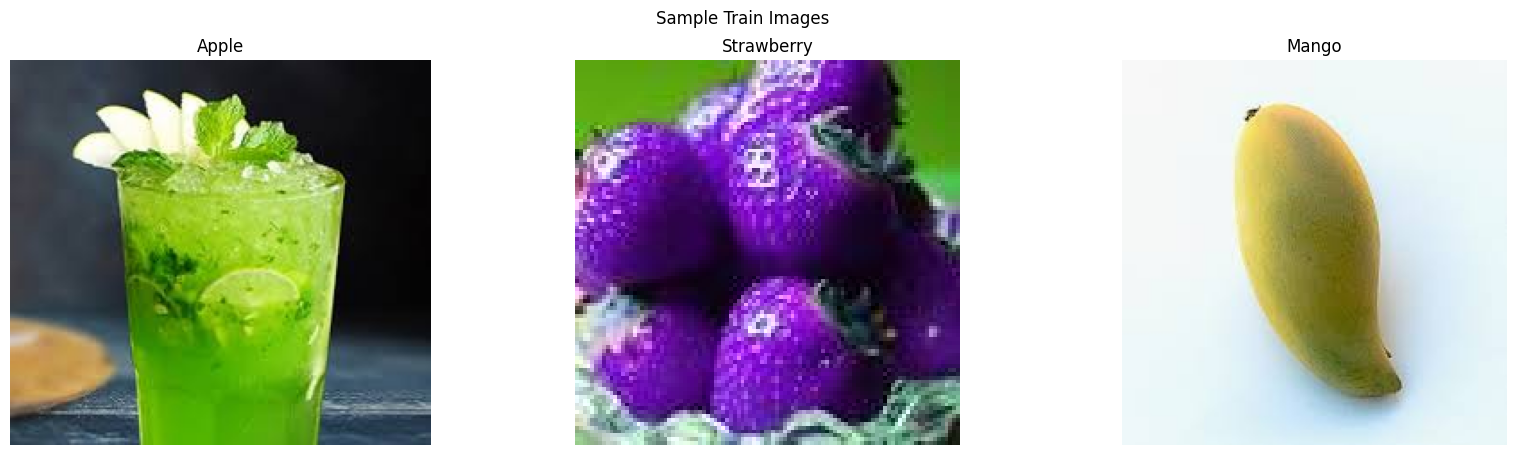

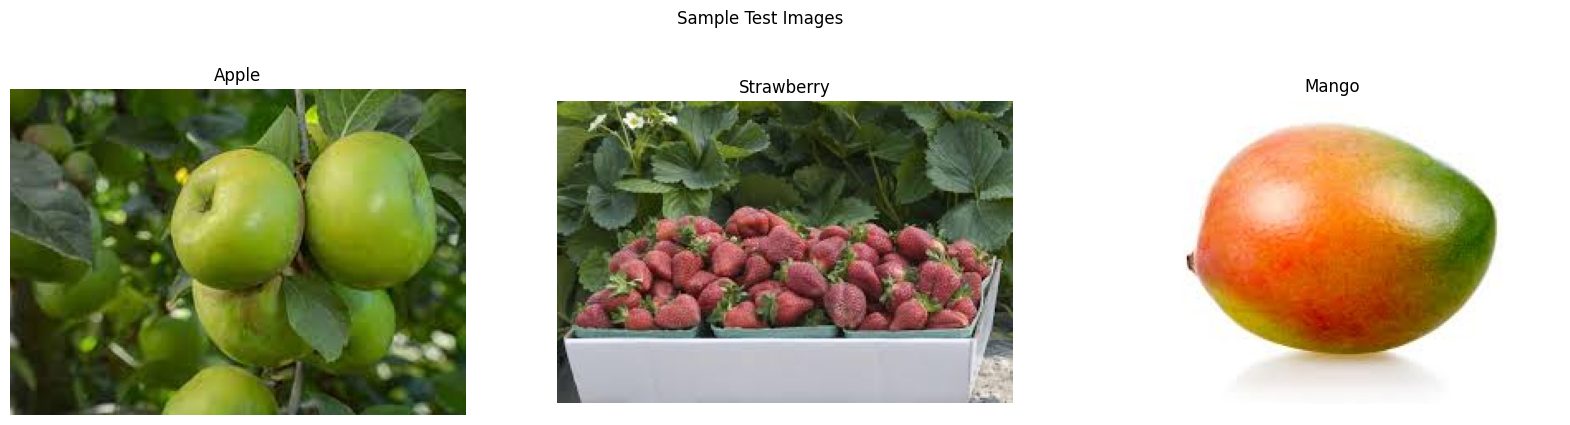

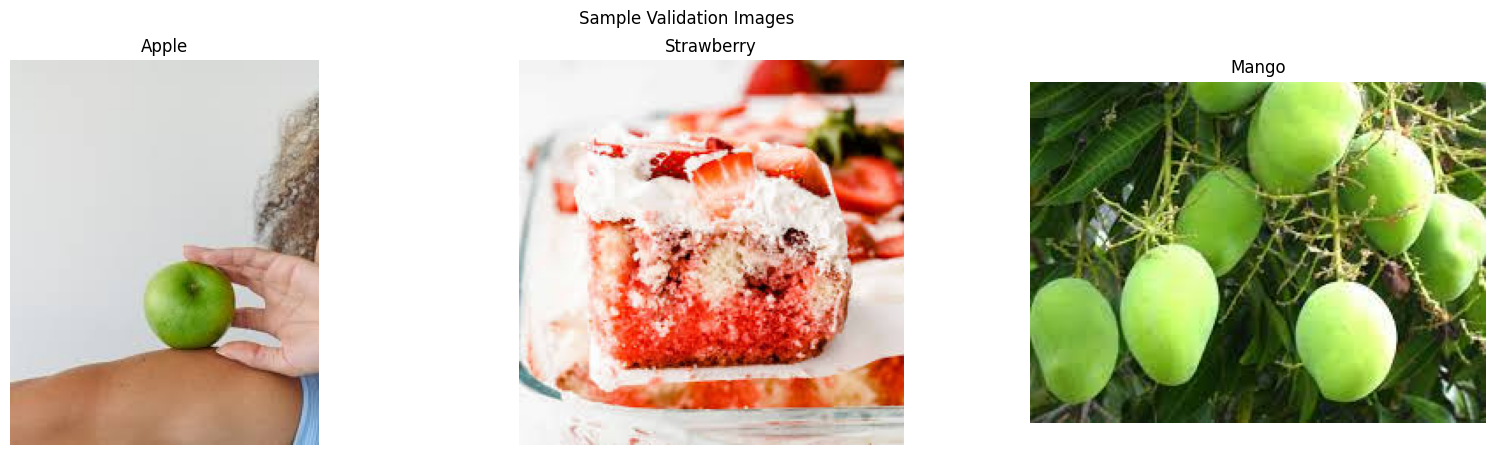

In [6]:
# Function to plot one image from each class in each folder
def plot_sample_images(folder, title):
    fig, axes = plt.subplots(1, len(os.listdir(folder)), figsize=(20, 5))
    fig.suptitle(title)
    for idx, class_folder in enumerate(os.listdir(folder)):
        class_folder_path = os.path.join(folder, class_folder)
        sample_image = random.choice(os.listdir(class_folder_path))
        img_path = os.path.join(class_folder_path, sample_image)
        img = imread(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_folder)
        axes[idx].axis('off')

# Plot sample images from each folder

plot_sample_images(train_dir, 'Sample Train Images')
plot_sample_images(test_dir, 'Sample Test Images')
plot_sample_images(valid_dir, 'Sample Validation Images')


 Data augmentation and normalization process:

 The ImageDataGenerator in deep learning frameworks like TensorFlow/Keras provides a convenient way to perform data augmentation and normalization on image data. It also normalizes images by scaling pixel values to a specific range.

In [7]:
# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 576 images belonging to 3 classes.
Found 144 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


Define the functions for comparison studies:


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_model_performance(histories, models, test_data, class_names):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'{models[i].name} Train Acc')
        plt.plot(history.history['val_accuracy'], label=f'{models[i].name} Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot Loss
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{models[i].name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{models[i].name} Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Print final training and validation accuracy and loss for each model
    for i, (model, history) in enumerate(zip(models, histories)):
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]

        print(f"\nModel: {model.name}")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")

        # Display confusion matrix
        test_labels = test_data.labels
        test_predictions = model.predict(test_data)
        predicted_labels = np.argmax(test_predictions, axis=1)

        cm = confusion_matrix(test_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot()
        plt.title(f'Confusion Matrix for {model.name}')
        plt.show()

        # Display the first five images from the test set with predictions
        plt.figure(figsize=(10, 5))
        for j in range(5):
            img, label = test_data[j]
            img = img[0]  # Get the image from the batch
            pred_label = np.argmax(test_predictions[j])
            actual_label = label[0]

            plt.subplot(1, 5, j+1)
            plt.imshow(img)
            plt.title(f"Actual: {class_names[actual_label]}\nPredicted: {class_names[pred_label]}")
            plt.axis('off')
        plt.suptitle(f'Predictions for {model.name}')
        plt.show()


Basic CNN model

In [9]:
# Define image size and number of classes
img_size = (224, 224)  #
num_classes = 3        # Number of classes in the classification


def build_cnn_model():
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
# Build and train the CNN model
model_CNN = build_cnn_model()
history_CNN = model_CNN.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - accuracy: 0.3715 - loss: 2.1209 - val_accuracy: 0.4861 - val_loss: 0.9737
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.4913 - loss: 0.9613 - val_accuracy: 0.6181 - val_loss: 0.7431
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.6411 - loss: 0.7987 - val_accuracy: 0.6875 - val_loss: 0.7115
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.6637 - loss: 0.7655 - val_accuracy: 0.6736 - val_loss: 0.6408
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7150 - loss: 0.6641 - val_accuracy: 0.7014 - val_loss: 0.6600
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.7103 - loss: 0.6733 - val_accuracy: 0.7431 - val_loss: 0.5887
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.6897 - loss: 0.6594 - val_accuracy: 0.6667 - val_loss: 0.6972
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.7280 - loss: 0.6427 - val_accuracy: 0

In [11]:


def plot_metrics(histories, model_names):
    print ("Model studied: ",  model_names)

    plt.figure(figsize=(10, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
       # Print the training and validation accuracy and loss
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Accuracy: {val_accuracy[-1]:.4f}")
        print(f"Training Loss: {train_loss[-1]:.4f}")
        print(f"Validation Loss: {val_loss[-1]:.4f}")
        plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
def predict_image(model, img_path, class_indices, img_size=(224, 224)):
    """
    Predict the class of an image using a pre-trained model.

    Parameters:
    - model: Trained Keras model
    - img_path: Path to the image file
    - class_indices: Dictionary mapping class names to indices
    - img_size: Tuple specifying the target size of the image

    Returns:
    - Predicted class name
    """
    try:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]

        # Get class names from class_indices
        class_names = {v: k for k, v in class_indices.items()}
        predicted_class_name = class_names.get(predicted_class_index, "Unknown")

        return predicted_class_name
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return "Error"

def plot_images_in_row(image_paths, predicted_classes, actual_classes, img_size=(224, 224)):
    """
    Plot a list of images in a single row with their predicted and actual class names.

    Parameters:
    - image_paths: List of image file paths
    - predicted_classes: List of predicted class names
    - actual_classes: List of actual class names
    - img_size: Tuple specifying the target size of the images
    """
    num_images = len(image_paths)
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        img = load_img(image_paths[i], target_size=img_size)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {predicted_classes[i]}\nActual: {actual_classes[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Model studied:  ['Model_CNN']
Training Accuracy: 0.7569
Validation Accuracy: 0.7500
Training Loss: 0.5922
Validation Loss: 0.5382


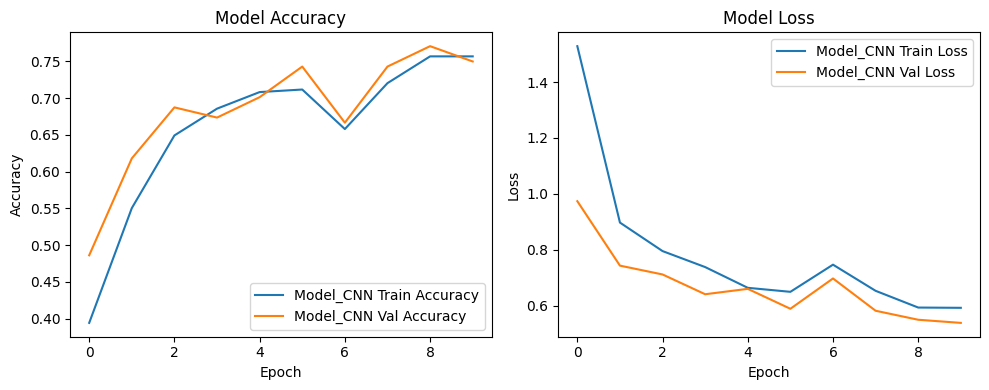

In [13]:
histories = [history_CNN]
model_names = ['Model_CNN']

plot_metrics(histories, model_names)

Hyperparameter tuning for CNN model

In [14]:

def build_model(hp):
    model = models.Sequential()

    # Add convolutional layers with hyperparameters
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                            (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_conv1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
                            (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_conv2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
                            (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_conv3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Flatten())

    # Dense layers with hyperparameters
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'nadam']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [15]:
import keras_tuner as kt
# Define the hyperparameter tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Number of hyperparameter configurations to try
    executions_per_trial=4,  # Number of models to train per configuration
    directory='kt_dir',
    project_name='fruit_classification'
)

# Search for the best hyperparameters
tuner.search(train_generator, validation_data=valid_generator, epochs=10)


Trial 2 Complete [00h 04m 57s]
val_accuracy: 0.7795138955116272

Best val_accuracy So Far: 0.7795138955116272
Total elapsed time: 00h 09m 58s


In [16]:
# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Build the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history_bestmodel = best_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


Best Hyperparameters:
conv1_filters: 96
dropout_conv1: 0.2
conv2_filters: 256
dropout_conv2: 0.30000000000000004
conv3_filters: 384
dropout_conv3: 0.2
dense_units: 128
dropout_dense: 0.1
optimizer: nadam
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.6973 - loss: 0.7248 - val_accuracy: 0.7986 - val_loss: 0.5885
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.7350 - loss: 0.5838 - val_accuracy: 0.7431 - val_loss: 0.6125
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7249 - loss: 0.6070 - val_accuracy: 0.7986 - val_loss: 0.5196
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.7803 - loss: 0.5757 - val_accuracy: 0.8264 - val_loss: 0.5612
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7933 - loss: 0.5580 - val_accuracy: 0.7847 - val_loss: 0.5819
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.8084 - loss: 0.4969 - val_accuracy: 0.8125 - val_loss: 0.5949
Epoch 7/10
18/18 ━━━━━━━━━━

Model studied:  ['Model_tunedCNN']
Training Accuracy: 0.7934
Validation Accuracy: 0.8056
Training Loss: 0.4949
Validation Loss: 0.5088


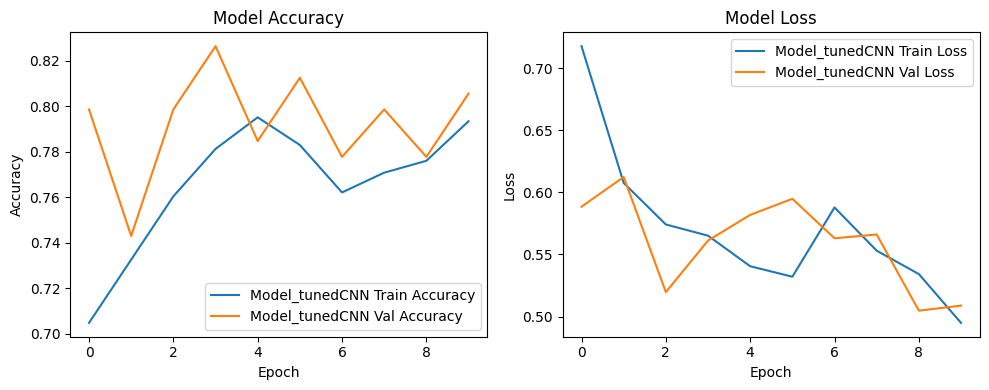

In [17]:
histories = [history_bestmodel]
model_names = ['Model_tunedCNN']

plot_metrics(histories, model_names)

Using ResNet50V2 model (without pre-trained weights):


In [18]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the ResNet50 model without pre-trained weights
base_model = ResNet50V2(include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)  # Adding another dense layer
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Compile the model with a suitable learning rate
model_ResNet50V2 = Model(inputs=base_model.input, outputs=predictions)
model_ResNet50V2.compile(optimizer=Adam(learning_rate=1e-4),  # Consider starting with a standard learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_ResNet50V2 = model_ResNet50V2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 706ms/step - accuracy: 0.5033 - loss: 0.9885 - val_accuracy: 0.8472 - val_loss: 0.3793
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.8718 - loss: 0.4202 - val_accuracy: 0.8958 - val_loss: 0.2611
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.9362 - loss: 0.2179 - val_accuracy: 0.9028 - val_loss: 0.2653
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.9511 - loss: 0.1620 - val_accuracy: 0.8750 - val_loss: 0.3487
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9925 - loss: 0.0649 - val_accuracy: 0.9097 - val_loss: 0.2573
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.9895 - loss: 0.0366 - val_accuracy: 0.9236 - val_loss: 0.2398
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.9741 - loss: 0.0703 - val_accuracy: 0.8958 - val_loss: 0.3075
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step 

Model studied:  ['Model_ResNet50V2']
Training Accuracy: 0.9705
Validation Accuracy: 0.9097
Training Loss: 0.0698
Validation Loss: 0.4414


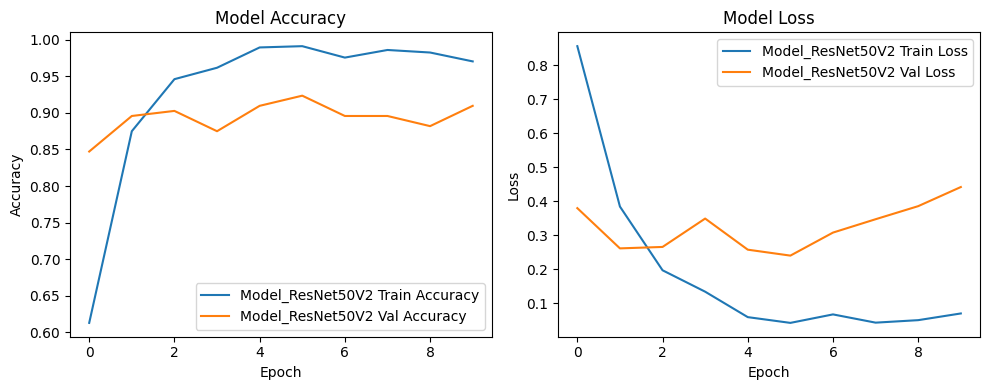

In [19]:

histories = [history_ResNet50V2]
model_names = ['Model_ResNet50V2']

plot_metrics(histories, model_names)

Using ResNet50V2 with pre-trained weights:

In [20]:

# Load the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Replace NUM_CLASSES with your actual number of classes

# Create the final model
model_ResNet50V2_pretrained = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_ResNet50V2_pretrained.compile(optimizer=Adam(learning_rate=1e-4),  # Fine-tuning requires a lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history_ResNet50V2_pretrained = model_ResNet50V2_pretrained.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,  # Set to the desired number of epochs
    verbose=1
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 598ms/step - accuracy: 0.5322 - loss: 0.9796 - val_accuracy: 0.8333 - val_loss: 0.4457
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.8629 - loss: 0.4090 - val_accuracy: 0.8750 - val_loss: 0.3735
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.8963 - loss: 0.2907 - val_accuracy: 0.8819 - val_loss: 0.3472
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9081 - loss: 0.2424 - val_accuracy: 0.8819 - val_loss: 0.3411
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9298 - loss: 0.2023 - val_accuracy: 0.8750 - val_loss: 0.3440
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9653 - loss: 0.1479 - val_accuracy: 0.8681 - val_loss: 0.3442
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9508 - loss: 0.1576 - val_accuracy: 0.8750 - val_loss: 0.3324
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.9687 - loss: 0.1547 - val_accuracy: 0

Model studied:  ['Model_ResNet50V2_pre-trained']
Training Accuracy: 0.9688
Validation Accuracy: 0.8889
Training Loss: 0.1081
Validation Loss: 0.3001


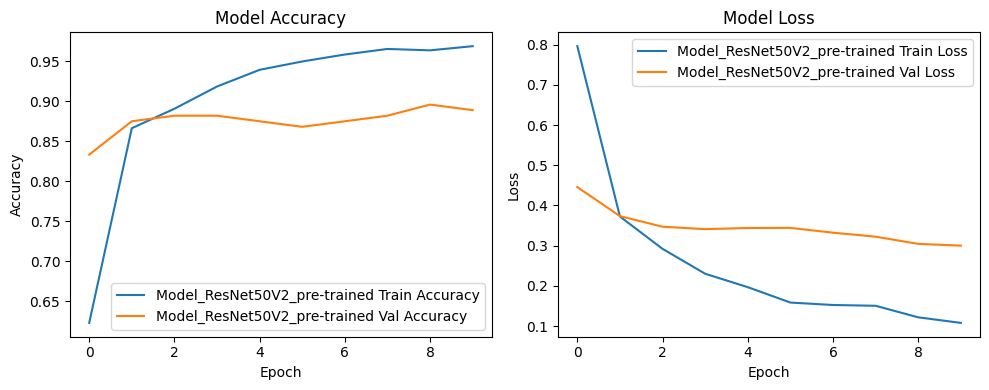

In [21]:
histories = [history_ResNet50V2_pretrained]
model_names = ['Model_ResNet50V2_pre-trained']

plot_metrics(histories, model_names)

### Vision Transformer from scratch 

In [22]:
#Defining the parameters for Vision transformers
# Define model parameters
img_size = 224
patch_size = 16
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]


Model Definition and Compilation:

Vision Transformer Model (ViT) Construction:

1.Input Layer: The model accepts images of shape (224, 224, 3).

2.Patch Creation: Input images are divided into patches using a 2D convolutional layer, followed by reshaping to a 2D array.

3.Positional Encoding: A positional encoding is added to the patches to maintain spatial information.

4.Transformer Blocks: Multiple transformer blocks are constructed, each consisting of: Layer Normalization: Standardizes inputs to have zero mean and unit variance.Multi-Head Attention: Captures different aspects of the input using multiple attention heads. Skip Connections: Residual connections that help in mitigating the vanishing gradient problem. MLP Block: A fully connected network that processes the output of the attention mechanism.

5.Output Representation: The output from the final transformer block is flattened, followed by dropout for regularization. 6.MLP Head: A final MLP block processes the flattened output. Output Layer: A dense layer with num_classes units provides the final logits for classification.

Model Compilation: The model is compiled with the Adam optimizer and categorical crossentropy loss. The metric used for evaluation is accuracy.

In [23]:
# Define the number of classes
num_classes = len(train_generator.class_indices)

# Helper functions
def mlp(x, hidden_units, dropout_rate):
    """Multi-layer perceptron."""
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    """Build the Vision Transformer model."""
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    # Create patches
    patches = tf.keras.layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patches = tf.keras.layers.Reshape((num_patches, -1))(patches)

    # Add positional encoding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + tf.keras.layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)

    # Create multiple transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Apply MLP to the final output
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)

    # MLP head
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Output layer
    logits = tf.keras.layers.Dense(num_classes)(features)
    output = tf.keras.layers.Activation('softmax')(logits)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

# Compile the model
model_VT = create_vit_classifier()
model_VT.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Training the Visual Transformer Model:

Callbacks:
EarlyStopping: Monitors the validation loss and stops training if it doesn't improve for a specified number of epochs (patience), restoring the best weights.

ReduceLROnPlateau: Reduces the learning rate if the validation loss stops improving, helping the model converge.


Model Training:
The model is trained using the train_generator for the training data and valid_generator for validation data. Training continues for up to 20 epochs unless early stopping is triggered.

In [24]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Train the model
history_VT = model_VT.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 884ms/step - accuracy: 0.3603 - loss: 10.5419 - val_accuracy: 0.3333 - val_loss: 1.3257 - learning_rate: 0.0010
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.3039 - loss: 4.7428 - val_accuracy: 0.3333 - val_loss: 2.2487 - learning_rate: 0.0010
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.3095 - loss: 3.4092 - val_accuracy: 0.3333 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.3685 - loss: 1.9602 - val_accuracy: 0.3333 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.3696 - loss: 1.3731 - val_accuracy: 0.3333 - val_loss: 1.1666 - learning_rate: 0.0010
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.3386 - loss: 1.3382 - val_accuracy: 0.3333 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.3022 - loss: 1.2694 

Model studied:  ['Model_VT']
Training Accuracy: 0.3177
Validation Accuracy: 0.3403
Training Loss: 1.1025
Validation Loss: 1.0982


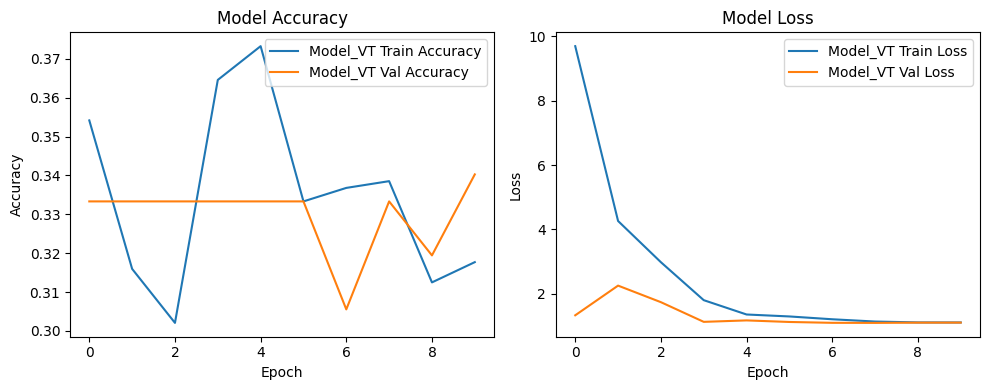

In [25]:
histories = [history_VT]
model_names = ['Model_VT']

plot_metrics(histories, model_names)

### Pretrained Visual Transformer- ViT16

In [26]:
!pip install pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [28]:
# Define transformations for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [29]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [30]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [31]:
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

In [33]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_validation_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

        # Save the model if validation accuracy improved
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Loss: {running_loss / len(train_loader):.4f} "
          f"Validation Accuracy: {validation_accuracy:.2f}%")

    # Adjust learning rate
    scheduler.step()


Epoch [1/10] Loss: 0.9771 Validation Accuracy: 87.50%
Epoch [2/10] Loss: 0.7042 Validation Accuracy: 90.28%
Epoch [3/10] Loss: 0.4855 Validation Accuracy: 92.36%
Epoch [4/10] Loss: 0.3561 Validation Accuracy: 93.75%
Epoch [5/10] Loss: 0.2461 Validation Accuracy: 93.75%
Epoch [6/10] Loss: 0.2033 Validation Accuracy: 95.83%
Epoch [7/10] Loss: 0.1911 Validation Accuracy: 95.14%
Epoch [8/10] Loss: 0.1675 Validation Accuracy: 96.53%
Epoch [9/10] Loss: 0.1456 Validation Accuracy: 95.14%
Epoch [10/10] Loss: 0.1482 Validation Accuracy: 96.53%


In [34]:
   # Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))
history_VIT_pretr = model
# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 95.56%


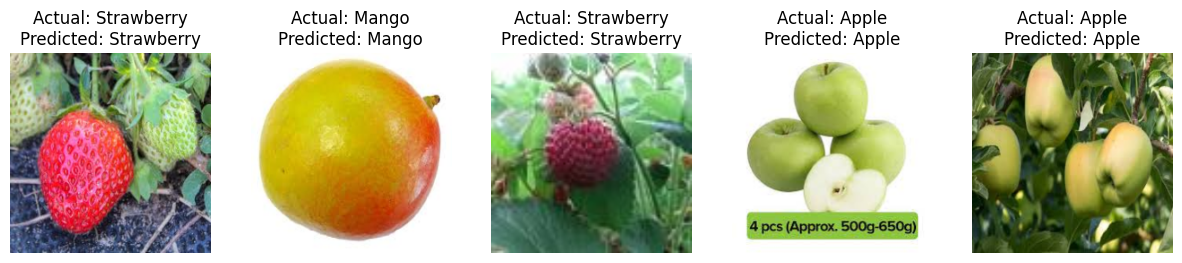

Test Accuracy: 95.56%


In [35]:
import torch
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
from torchvision import transforms

# Function to display an image with predicted and actual labels
def imshow(img, actual_label, predicted_label):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.cpu().numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose to (H, W, C) format
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Get class indices from the training generator
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Randomly select 5 images from the test set
test_image_files = [os.path.join(root, file) for root, _, files in os.walk('/content/Fruit_class_project/test') for file in files]
sample_images = random.sample(test_image_files, 5)

# Transformation to be applied on the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize the images
])

# List to store images, actual labels, and predicted labels
images, actual_labels, predicted_labels = [], [], []

# Process each sample image
for img_path in sample_images:
    # Extract actual class name from the path
    actual_class_name = os.path.basename(os.path.dirname(img_path))

    # Load the image
    image = Image.open(img_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.logits, 1)
        predicted_class_name = index_to_class[predicted.item()]

    # Store the image and labels
    images.append(image_tensor.squeeze(0))
    actual_labels.append(actual_class_name)
    predicted_labels.append(predicted_class_name)

# Plot the images with their labels
fig = plt.figure(figsize=(15, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    imshow(images[i].cpu(), actual_labels[i], predicted_labels[i])
plt.show()

# Calculate test accuracy
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


### Comparison studies using different Models:

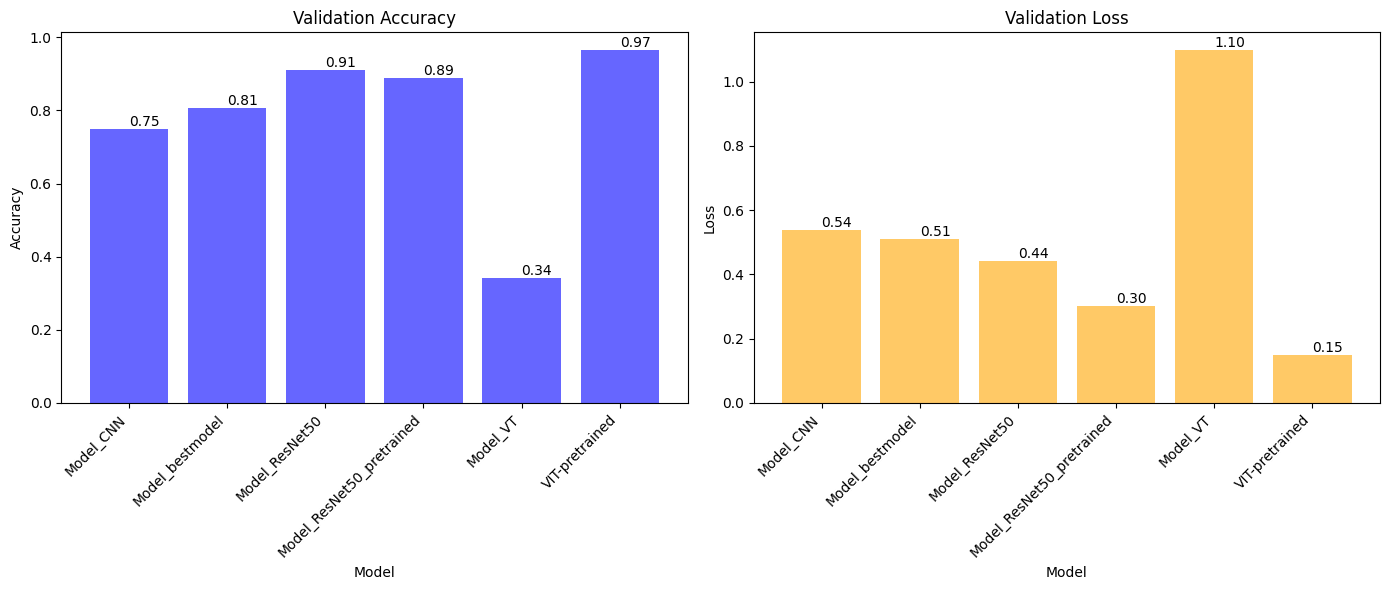

In [36]:

def plot_metrics(histories, model_names, best_val_acc, best_val_loss, best_model_name):
    # Extract the final validation accuracy and loss for each model
    val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
    val_losses = [history.history['val_loss'][-1] for history in histories]

    # Add the best validation accuracy and loss for the model without history
    val_accuracies.append(best_val_acc)
    val_losses.append(best_val_loss)

    # Add the model name
    model_names.append(best_model_name)

    x = np.arange(len(model_names))  # the label locations

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Bar plot for validation accuracy
    bars_acc = ax[0].bar(x, val_accuracies, align='center', alpha=0.6, color='blue')
    ax[0].set_xlabel('Model')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Validation Accuracy')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(model_names, rotation=45, ha='right')

    # Add text annotations for validation accuracy
    for bar in bars_acc:
        yval = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # va='bottom' places text above the bar

    # Bar plot for validation loss
    bars_loss = ax[1].bar(x, val_losses, align='center', alpha=0.6, color='orange')
    ax[1].set_xlabel('Model')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Validation Loss')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(model_names, rotation=45, ha='right')

    # Add text annotations for validation loss
    for bar in bars_loss:
        yval = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # va='bottom' places text above the bar

    plt.tight_layout()
    plt.show()

# Replace with your history objects
histories = [history_CNN, history_bestmodel, history_ResNet50V2, history_ResNet50V2_pretrained, history_VT]
model_names = ['Model_CNN', 'Model_bestmodel', 'Model_ResNet50', 'Model_ResNet50_pretrained', 'Model_VT']
best_val_acc = best_validation_accuracy/100
best_val_loss = running_loss / len(train_loader)
best_model_name = 'VIT-pretrained'

plot_metrics(histories, model_names, best_val_acc, best_val_loss, best_model_name)


### Results:

The Pretrained VIT model outperforms all other models in both accuracy and loss, indicating it is the most effective model for the given task.

VIT Constructed from Scratch model shows the lowest accuracy and highest loss, indicating poor performance. This indicates potential issues with the model architecture or training process.

Other models such as Pretrained ResNet50V2, ResNet50V2, Tuned CNN, and CNN models also perform well but not as effectively as the Pretrained VIT.

### Conclusion:

In this evaluation of various models, the Pretrained Vision Transformer (VIT) emerged as the standout performer, achieving the highest validation accuracy of 0.97 and the lowest validation loss of 0.15. This indicates that the Pretrained VIT is highly effective for the task at hand, demonstrating superior predictive accuracy and robust performance. Although more complex models like Pretrained VIT tend to perform better, but they may require more computational resources and careful tuning.
Overall, the results underscore the advantages of leveraging pretrained models, especially for complex architectures like VIT, which offer substantial gains in performance.